# F-test

#### Imports

In [1]:
'''
Credit to GitHub user Jaimin09
Link: https://github.com/Jaimin09/Coding-Lane-Assets/tree/main/Logistic%20Regression%20in%20Python%20from%20Scratch
Last accessed: 28/10/2021
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import copy
import scipy
from scipy import stats

# ! Set seed and seed calling function
rng = np.random.default_rng(1)

# ! Get dataset
filepath = 'dec_sep_MPHWAE.csv'
df = pd.read_csv(filepath)
df= df.reset_index()

dec_path = 'dec_MPHWA.csv'
dec_df = pd.read_csv(dec_path)
dec_df = dec_df.reset_index()

#### Reshape

In [2]:
def Reshape(X, Y):
    # Drop id column from dataframes
    X = X.drop("ID", axis = 1)
    Y = Y.drop("ID", axis = 1)
    
    # Define dataframes as variables
    X = X.values
    Y = Y.values
    
    # Reshape dataframes to appropriate shape
    X = X.T
    Y = Y.reshape(1, X.shape[1])
    
    return X, Y

#### Even out the dataframe

In [3]:
def EvenDF(df):
    # Split dataframe into won a medal and didnt win a medal
    df_1 = df[df.MedalEarned == 1]
    df_0 = df[df.MedalEarned == 0]
    
    # Randomly sample df_0 to size of df_1
    df_0 = df_0.sample(n = len(df_1), random_state=rng.integers(100000))
    
    return df_1, df_0

### Test sampler

In [4]:
def TestSampler(df, X_list, Y_list):
    # Split dataframe into won a medal and didnt win a medal
    df_1 = df[df.MedalEarned == 1]
    df_0 = df[df.MedalEarned == 0]
    
    # Randomly sample test df_1 and df_0
    df_1_test = df_1.sample(n = 100, random_state=rng.integers(100000))
    df_0_test = df_0.sample(n = 100, random_state=rng.integers(100000))
    
    # Remove test samples from df_1 and df_0
    df = df.drop(df_1_test.index)
    df_testless = df.drop(df_0_test.index)
    
    # Concat df_1_test and df_0_test
    df_test_list = [df_1_test, df_0_test]
    df_test = pd.concat(df_test_list)
    
    # Reduce and split X and Y dataframes
    X_test = df_test[X_list]
    Y_test = df_test[Y_list]
    
    return df_testless, X_test, Y_test

### Train and validate sampler

In [5]:
def TrainValidate(df, X_list, Y_list):
    # Randomly sample df_0 to size of df_1
    df_1, df_0 = EvenDF(df)
    
    # Randomly sample validate df_1 and df_0
    df_1_validate = df_1.sample(frac= 0.2, random_state=rng.integers(100000))
    df_0_validate = df_0.sample(frac= 0.2, random_state=rng.integers(100000))
    
    # Remove validation samples from df_1 and df_0
    # The rest of df_1 and df_0 are training
    df_1_train = df_1.drop(df_1_validate.index)
    df_0_train = df_0.drop(df_0_validate.index)
    
    # concatinate training and validation
    df_validate_list = [df_1_validate, df_0_validate]
    df_train_list =    [df_1_train, df_0_train]
    
    df_validate = pd.concat(df_validate_list)
    df_train =    pd.concat(df_train_list)
    
    # Reduce and split X and Y dataframes
    X_validate = df_validate[X_list]
    Y_validate = df_validate[Y_list]
    X_train =    df_train[X_list]
    Y_train =    df_train[Y_list]
    
    return X_train, Y_train, X_validate, Y_validate

#### Sigmoid

In [6]:
def Sigmoid(x):
    return 1/(1 + np.exp(-x))

### Logistic regression model

In [7]:
def Model(X, Y, l_rate, iterations):
    m = X.shape[1] # Observations
    n = X.shape[0] # Types of parameters
    
    W = np.zeros((n,1)) # All a parameters
    B = 0
    
    cost_list = [] # Empty cost list
    
    for i in range(iterations):
        lin_func = np.dot(W.T, X) + B # Linear function
        sf = Sigmoid(lin_func) # Sigmoid function
        
        # Cost function
        cost = -(1/m)*np.sum( Y*np.log(sf) + (1-Y)*np.log(1-sf))
        
        # Gradient Descent
        dW = (1/m)*np.dot(sf-Y, X.T)
        dB = (1/m)*np.sum(sf - Y)
        
        W = W - l_rate * dW.T
        B = B - l_rate * dB
        
        # Keeping track of our cost function value
        cost_list.append(cost)
    
    return W, B, cost_list

## Run model

In [8]:
def RunModel(df_testless, iterations, l_rate):
    # Make X_train, Y_train, X_validate, Y_validate
    X_train, Y_train, X_validate, Y_validate = TrainValidate(df_testless, X_list, Y_list)
    
    # Import and reshape training and validation dataframes
    X_train, Y_train = Reshape(X_train, Y_train)
    X_validate, Y_validate = Reshape(X_validate, Y_validate)
    
    # Call Model function
    W, B, cost_list = Model(X_train, Y_train, l_rate, iterations)
    
    return W, B

## Multiple runs of model

In [9]:
X_list = ['ID', 
        'Height_div_avg', 
        'Weight_div_avg', 
        'Age_div_avg'
        ]

Y_list = ['ID', 'MedalEarned']

def RunMore(times, iterations, l_rate):
    W_list = []
    B_list = []
    
    # Create test sample
    df_testless, X_test, Y_test = TestSampler(df, X_list, Y_list)
    
    for i in range(times):
        # Run model
        W, B = RunModel(df_testless, iterations, l_rate)
        
        # Append parameters, accuracy and occurances to lists
        W_list.append(W)
        B_list.append(B)
        
        # Progress bar
        if len(W_list) % 10 == 0:
            print(f'{times - len(W_list)} runs left.')
    
    return W_list, B_list

## Classify

In [10]:
def Classify(X, W, B, cop):
    lin_func = np.dot(W.T, X) + B # Linear function
    sf = Sigmoid(lin_func) # Sigmoid function
    
    # Make sf binary array with data type int64
    sf = sf > cop # Sets sf to one if > 0 or 0 if < 0
    sf = np.array(sf, dtype = 'int64')
    
    return sf

## Accuracy

In [11]:
def Accuracy(sf, Y):
    # 1 = True Pos, 0 = True Neg, -1 = False Neg, 2 = False Pos 
    guesses = sf * 2 - Y
    occurance = [[x, list(guesses[0]).count(x)] for x in set(list(guesses[0]))]
    occ_d = {1:0, 0:0, -1:0, 2:0}
    
    # Assign value to keys e.g. TP : 22
    for i in occurance: 
        occ_d[i[0]] = i[1]
    
    # True Positive, True Negative, False Positive and False Negative
    tp, tn, fp, fn = occ_d[1], occ_d[0], occ_d[2], occ_d[-1]
    
    # Calculate accuracy
    acc = (tp + tn) / (tp + tn + fp + fn)
    
    return acc, occ_d

## Decathlon

In [12]:
def Decathlon(df, W_list, B_list, cop):
    dec_acc_list = []
    dec_occ_list = []
    
    # Reduce and split X and Y dataframes
    X_dec = df[X_list]
    Y_dec = df[Y_list]
    
    # Import and reshape dec data
    X_dec, Y_dec = Reshape(X_dec, Y_dec)
    
    # Test parameters on dec
    for i in range(len(W_list)):
        sf = Classify(X_dec, W_list[i], B_list[i], cop)
        da, dod = Accuracy(sf, Y_dec)
        dec_acc_list.append(da)
        dec_occ_list.append(dod)
    
    return dec_acc_list, dec_occ_list

# Execute model

In [13]:
W_list, B_list = RunMore(times= 50, iterations= 5000, l_rate= 0.02)

40 runs left.
30 runs left.
20 runs left.
10 runs left.
0 runs left.


# F-test

# To do liste
normalitetstest færdig for en gang 
f-test færdig for en en gang 
generaliser til en funktion, som kan gøre det for de parametre, der giver den højeste accuracy 

In [14]:
# Classify til f_test 
def Classify_f(df, W, B):
    
    # Få data til model 
    X_dims = df[X_list] 
    Y_dims = df[Y_list]
    X_dims, Y_dims = Reshape(X_dims, Y_dims)
    
    # Få modelgæt
    lin_func = np.dot(W.T, X_dims) + B # Linear function
    sf = Sigmoid(lin_func) # Sigmoid function
    
    return sf

# Få liste af modelgæt, når w er udændret
sig_0 = Classify_f(df, W_list[0], B_list[0])
print(sig_0)
sig_0_sum = np.sum(sig_0)
print(sig_0_sum)

# Få liste af modelgæt, når w_i = 0 er udændret

# Lav en kopi af modelvægte, og sæt den første til 0
W1_list = copy.deepcopy(W_list)
W1_list[0][0] = 0 

sig_1 = Classify_f(df, W1_list[0], B_list[0])
print(sig_1)
sig_1_sum = np.sum(sig_1)
print(sig_1_sum)



[[0.48712908 0.68935158 0.59100899 ... 0.33180352 0.6255091  0.43004284]]
2918.9569482045245
[[0.52490506 0.58202323 0.48710159 ... 0.38759193 0.49806718 0.447825  ]]
2910.1222035173505


ShapiroResult(statistic=0.9993399977684021, pvalue=0.02164579927921295)


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


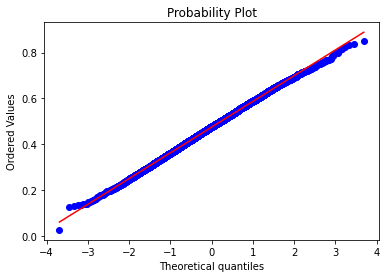

In [15]:
x = scipy.stats.shapiro(sig_0)
print(x)
df_bonk = pd.DataFrame(sig_0.T, columns = ['sig_0'])
q = scipy.stats.probplot(df_bonk['sig_0'], dist = 'norm', plot = plt)
plt.show(q)

## The f test

In [16]:
#define F-test function
def f_test(x, y):
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f, p

#perform F-test
f_test(sig_0, sig_1)

(4.617018783541158, 1.1102230246251565e-16)